In [115]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfw-people-flatten-data/lfwpeople.csv


# **Installing The Requirements**

In [116]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten,MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet101
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19


# **Load The Data Using Pandas**

In [117]:
dataframe = pd.read_csv("../input/lfw-people-flatten-data/lfwpeople.csv")

In [118]:
target_mappings = dataframe[["target_classes","target_names"]].set_index(["target_classes"]).to_dict()
target_mappings["target_names"]

{2: 'George W Bush',
 3: 'Gerhard Schroeder',
 1: 'Donald Rumsfeld',
 4: 'Tony Blair',
 0: 'Colin Powell'}

# **Preprocessing The Data**

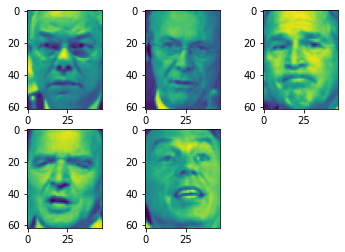

In [119]:
for idx,i in enumerate(range(len(set(dataframe['target_classes'])))):
    rows, cols = 2, 3
    plt.subplot(rows, cols, idx+1)
    plt.imshow(dataframe[dataframe['target_classes'] ==i].iloc[:1,2:].values.reshape(62,47))

In [120]:
pixcels = dataframe.iloc[:,2:]
def rename_cols(pixcel): 
    columns = list()
    for i in range(pixcel.shape[1]):
        columns.append("col_"+str(i))   
    img_data = dataframe.iloc[:,2:].rename(columns = dict(zip(dataframe.iloc[:,2:].columns.tolist(),columns)))
    label_data = dataframe.iloc[:,:2]
    data = label_data.join(img_data)
    return data
data = rename_cols(pixcels)

#X_train = np.array(data.iloc[:500,2:])
#X_test = np.array(data.iloc[500:,2:])

#y_train =  np.array(data.iloc[:500,1:2])
#y_test = np.array(data.iloc[500:,1:2])

In [121]:
train,val = train_test_split(dataframe,test_size=0.2,stratify=dataframe.iloc[:,1].values)

In [122]:
X_train = train.iloc[:,2:].values
y_train = train.iloc[:,1].values
X_test = val.iloc[:,2:].values
y_test = val.iloc[:,1].values

In [123]:
def dim_increase(pixcels):
    dim_3d = list()
    for pixcel in pixcels:
        one_img = pixcel.reshape(62,47)
        merge_img = cv2.merge([one_img,one_img,one_img])
        dim_3d.append(merge_img.astype('float32')/255.0)
    return dim_3d
X_train = np.array(dim_increase(X_train))
X_test = np.array(dim_increase(X_test))

# **Modelling** 

In [124]:
model = Sequential()
# The first two layers with 32 filters of window size 3x3
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(62,47,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))


model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 62, 47, 32)        896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 31, 23, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 31, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 15, 11, 64)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 15, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 7, 5, 64)          0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 7, 5, 64)        

In [125]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# **Training Model**

In [126]:
model.fit(X_train, y_train, batch_size=10, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
92/92 [==============================] - 3s 25ms/step - loss: 1.4246 - accuracy: 0.4627 - val_loss: 1.4012 - val_accuracy: 0.4649
Epoch 2/50
92/92 [==============================] - 2s 23ms/step - loss: 1.3339 - accuracy: 0.4836 - val_loss: 1.2556 - val_accuracy: 0.4737
Epoch 3/50
92/92 [==============================] - 2s 23ms/step - loss: 1.0014 - accuracy: 0.6118 - val_loss: 0.9216 - val_accuracy: 0.7105
Epoch 4/50
92/92 [==============================] - 2s 24ms/step - loss: 0.6618 - accuracy: 0.7610 - val_loss: 0.4605 - val_accuracy: 0.8289
Epoch 5/50
92/92 [==============================] - 2s 23ms/step - loss: 0.4759 - accuracy: 0.8235 - val_loss: 0.3716 - val_accuracy: 0.8991
Epoch 6/50
92/92 [==============================] - 3s 31ms/step - loss: 0.3465 - accuracy: 0.8860 - val_loss: 0.2583 - val_accuracy: 0.9079
Epoch 7/50
92/92 [==============================] - 2s 23ms/step - loss: 0.2321 - accuracy: 0.9211 - val_loss: 0.2191 - val_accuracy: 0.9211
Epoch 8/50
92

# **Plotting** 

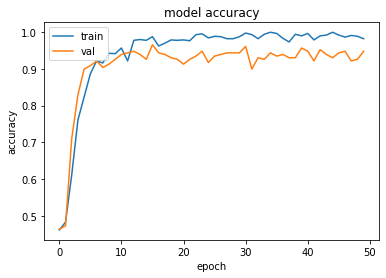

In [127]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

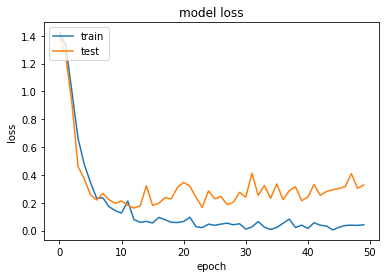

In [128]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Predict**

Real : Colin Powell
Predicted : Colin Powell
--------------------------------------------------


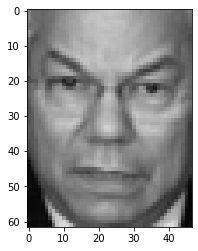

Real : Donald Rumsfeld
Predicted : Donald Rumsfeld
--------------------------------------------------


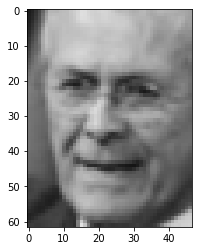

Real : George W Bush
Predicted : George W Bush
--------------------------------------------------


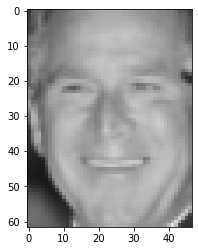

Real : Colin Powell
Predicted : Colin Powell
--------------------------------------------------


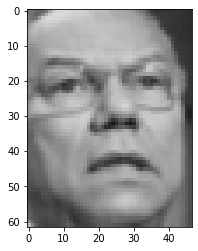

Real : Gerhard Schroeder
Predicted : Gerhard Schroeder
--------------------------------------------------


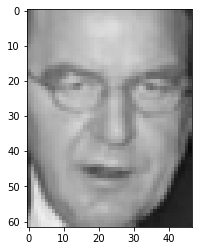

In [129]:
idx = 1
for idx in range(10,15):
    input_img = X_test[idx,:]
    label = val.iloc[idx,0]
    print("Real : {}".format(label))
    cls = model.predict(input_img.reshape(1,62,47,3))
    print("Predicted : {}".format(target_mappings["target_names"][np.argmax(cls[0])]))
    print("-"*50)
    plt.imshow(input_img.reshape(62,47,3))
    plt.show()